In [1]:
# Import required libraries
from src.ml import RegressorFramework
from src.feature import get_shap, get_vips
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load ASV and amino acid data
asv_path = "./data/ASVs.csv"
amino_acid_path = "./data/AAs.csv"
asv = pd.read_csv(asv_path, index_col=0)
amino_acid = pd.read_csv(amino_acid_path, index_col=0)

In [3]:
# Selected ASVs for network analysis
asv_name_list = [
    'B_ASV_98229', 'B_ASV_95119', 'B_ASV_83738', 'B_ASV_79875', 'B_ASV_78240',
    'B_ASV_77896', 'B_ASV_70040', 'B_ASV_68290', 'B_ASV_59582', 'B_ASV_48893',
    'B_ASV_38043', 'B_ASV_35282', 'B_ASV_19290', 'B_ASV_17952', 'B_ASV_15625',
    'B_ASV_143173', 'B_ASV_142812', 'B_ASV_140470', 'B_ASV_137520', 'B_ASV_135906',
    'B_ASV_131779', 'B_ASV_129877', 'B_ASV_125122', 'B_ASV_102823', 'B_ASV_100340'
]

In [4]:
# Set up feature importance sorting models
models = {
    "PLS Regression": PLSRegression(),
    "XGBoost": XGBRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

In [5]:
# Compute feature importance scores for each amino acid using different models
aa_feature = {}

for aa in amino_acid.columns:
    feature_df = pd.DataFrame()

    for name, model in models.items():
        X = asv.loc[:, asv.columns.isin(asv_name_list)]
        y = amino_acid[aa]
        X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

        reg = RegressorFramework(model)
        reg.fit(X_shuffled, y_shuffled)

        # Extract feature importance using appropriate method
        if name == "PLS Regression":
            df_sorted = get_vips(X_shuffled, reg.model)
        elif name == "XGBoost":
            df_sorted = get_shap(X_shuffled, reg.model)
        elif name == "Random Forest":
            feature = reg.model.feature_importances_
            df_sorted = pd.DataFrame({'Scores': feature}, index=X_shuffled.columns)
            df_sorted.sort_values(by='Scores', ascending=False, inplace=True)
        else:
            raise Exception(f"Unsupported model type: {name}")

        # Normalize scores
        scores = df_sorted['Scores']
        normalized = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

        feature_df[name] = normalized

    # Compute mean importance score across all models
    # Here, we can perform a weighted summation of the feature importance scores of the three methods based on the importance of the model.
    feature_df['mean_score'] = feature_df.mean(axis=1)
    top_feature = feature_df['mean_score'].sort_values(ascending=False)

    # Save top features per amino acid
    aa_feature[aa] = top_feature.index.to_list()

In [6]:
# Check the top features (ASVs) for Amino acid
aa_feature['Cys']

['B_ASV_131779',
 'B_ASV_142812',
 'B_ASV_143173',
 'B_ASV_15625',
 'B_ASV_38043',
 'B_ASV_137520',
 'B_ASV_95119',
 'B_ASV_35282',
 'B_ASV_77896',
 'B_ASV_129877',
 'B_ASV_125122',
 'B_ASV_78240',
 'B_ASV_68290',
 'B_ASV_19290',
 'B_ASV_100340',
 'B_ASV_70040',
 'B_ASV_59582',
 'B_ASV_135906',
 'B_ASV_98229',
 'B_ASV_83738',
 'B_ASV_48893',
 'B_ASV_140470',
 'B_ASV_102823',
 'B_ASV_79875',
 'B_ASV_17952']

In [7]:
# Count how often each ASV appears in the top 3 for any amino acid
count = {}
for aa in aa_feature:
    for feature in aa_feature[aa][:3]:
        if feature not in count:
            count[feature] = 1
        else:
            count[feature] += 1

# Sort ASVs by frequency
target_asv_count = sorted(count.items(), key=lambda x: x[1], reverse=True)

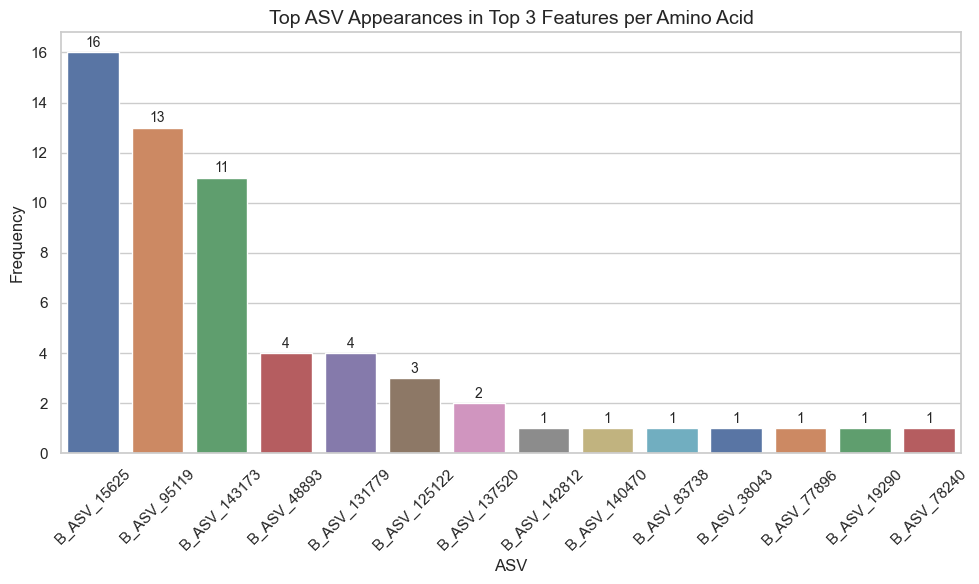

In [8]:
asv_df = pd.DataFrame(target_asv_count, columns=['ASV', 'Count'])
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='ASV', 
    y='Count', 
    hue='ASV',
    data=asv_df, 
    palette='deep', 
    dodge=False,
    legend=False
)

for i, v in enumerate(asv_df['Count']):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)

plt.title('Top ASV Appearances in Top 3 Features per Amino Acid', fontsize=14)
plt.xlabel('ASV', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

In [9]:
# Upset plot data
asv_to_aas = {}
for aa, features in aa_feature.items():
    for asv_top in features[:3]:
        if asv_top not in asv_to_aas:
            asv_to_aas[asv_top] = [aa]
        else:
            asv_to_aas[asv_top].append(aa)

max_len = max(len(v) for v in asv_to_aas.values())
asv_df = pd.DataFrame({asv: v + [None]*(max_len - len(v)) for asv, v in asv_to_aas.items()})
asv_df.head()

,B_ASV_15625,B_ASV_95119,B_ASV_48893,B_ASV_131779,B_ASV_125122,B_ASV_143173,B_ASV_142812,B_ASV_137520,B_ASV_140470,B_ASV_83738,B_ASV_38043,B_ASV_77896,B_ASV_19290,B_ASV_78240
0,Asp,Asp,Asp,Pro,Met,Phe,Cys,Gly,Trp,Trp,Arg,Gln,Gln,Asn
1,Pro,Pro,Glu,Cys,Gln,Val,None,Ser,None,None,None,None,None,None
2,Met,Met,Trp,Tyr,Asn,Cys,None,None,None,None,None,None,None,None
3,Phe,Phe,Arg,Lys,None,His,None,None,None,None,None,None,None,None
4,Val,Val,None,None,None,Gly,None,None,None,None,None,None,None,None


In [10]:
# Set up ASVs feature number selection models
models = {
    "Bagging": BaggingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
}

In [11]:
# Evaluate model performance using an increasing number of top ASVs
target_asv_list = [i[0] for i in target_asv_count]
results = []

for i in range(2, len(target_asv_list) + 1):
    target_asv = target_asv_list[:i]

    for name, model in models.items():
        for aa in amino_acid.columns:
            X = asv.loc[:, asv.columns.isin(target_asv)]
            y = amino_acid[aa]
            X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

            reg = RegressorFramework(model)
            r2_score, rmse_score = reg.cross_validate(X_shuffled, y_shuffled)

            results.append({
                'num_asv': i,
                'model': name,
                'amino_acid': aa,
                'r2': r2_score,
                'rmse': rmse_score
            })

# Save results into a DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv("./data/asv_num_selection_results.csv", index=False)
results_df.head()

,num_asv,model,amino_acid,r2,rmse
0,2,Bagging,Asp,0.393564,0.175563
1,2,Bagging,Pro,0.085198,1.816788
2,2,Bagging,Met,0.648919,0.116602
3,2,Bagging,Phe,0.565153,0.647384
4,2,Bagging,Val,0.500685,0.822580


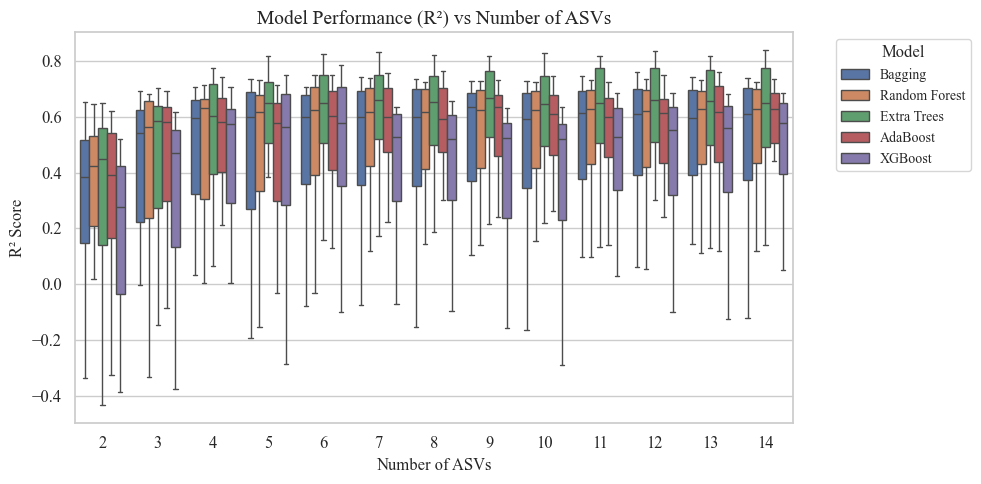

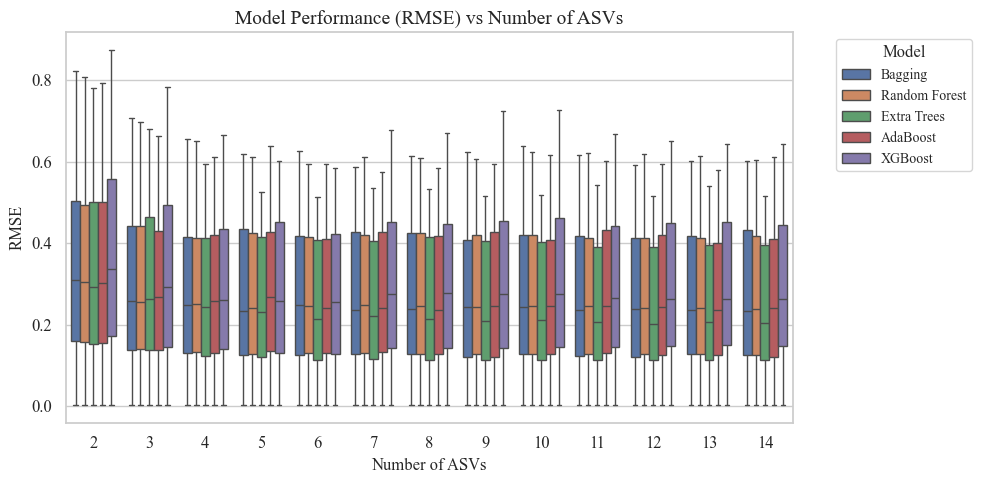

In [12]:
# Set style for the plots
sns.set(style="whitegrid")

# Define font properties for publication
plt.rcParams.update({
    'font.size': 12,  # Set default font size for general text
    'axes.labelsize': 12,  # Label size for axes
    'xtick.labelsize': 12,  # X-axis tick label size
    'ytick.labelsize': 12,  # Y-axis tick label size
    'legend.fontsize': 10,  # Legend font size
    'figure.figsize': (7, 5),  # Set figure size to be appropriate for publications
    'font.family': 'Times New Roman',  # Set font family to Times New Roman
    'axes.titlesize': 14,  # Set title font size for axes
})

# R² boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=results_df, x='num_asv', y='r2', hue='model', showfliers=False)
plt.xlabel("Number of ASVs")
plt.ylabel("R² Score")
plt.title("Model Performance (R²) vs Number of ASVs")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the first plot as a separate PDF
# plt.savefig("model_performance_r2_vs_num_asv.pdf", format="pdf")
plt.show()
plt.close()  # Close the figure to avoid overlapping with the next one

# RMSE boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=results_df, x='num_asv', y='rmse', hue='model', showfliers=False)
plt.xlabel("Number of ASVs")
plt.ylabel("RMSE")
plt.title("Model Performance (RMSE) vs Number of ASVs")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the second plot as a separate PDF
# plt.savefig("model_performance_rmse_vs_num_asv.pdf", format="pdf")
plt.show()
plt.close()  # Close the figure